In [1]:
import pm4py
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

c:\Users\Martin\Desktop\Quarter 2\Advanced Process Mining\Project\process-mining-project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# --- 1. CONFIGURATION ---
LOG_FILE = "./BPI_Challenge_2017.xes"
DECISION_POINT = "A_Complete"

In [14]:
# --- 2. DATA LOADING ---
log = pm4py.read_xes(LOG_FILE)
df = pm4py.convert_to_dataframe(log)

Loading Event Log...


parsing log, completed traces :: 100%|██████████| 31509/31509 [00:45<00:00, 687.12it/s]


Using Data Columns: CreditScore, NumberOfTerms


In [18]:
# Sort by Case and Time to ensure sequential order
if 'time:timestamp' in df.columns:
    df = df.sort_values(by=['case:concept:name', 'time:timestamp'])

In [40]:
# Identify useful data columns dynamically
cols = df.columns.tolist()
# 'CreditScore' is often a key driver for cancellations
score_col = next((c for c in cols if 'CreditScore' in c or 'score' in c.lower()), None)
# 'MonthlyCost' or 'LoanGoal' are also useful
# amount_col = next((c for c in cols if 'RequestedAmount' in c or 'Amount' in c), None)
terms_col = next((c for c in cols if 'Terms' in c or 'term' in c.lower()), None)

print(f"Using Data Columns: {score_col}, {terms_col}")

Using Data Columns: CreditScore, NumberOfTerms


In [ ]:
# --- 3. FEATURE ENGINEERING (Prefix Extraction) ---
# We group by case and "cut" the trace at 'A_Complete'
case_groups = df.groupby("case:concept:name")

data_rows = []
labels = []
case_ids = []

unique_activities = df["concept:name"].unique()
act_to_int = {act: i for i, act in enumerate(unique_activities)}

print("Extracting Features...")
for case_id, group in tqdm(case_groups):
    events = group["concept:name"].tolist()
    timestamps = group["time:timestamp"].tolist()
    
    # FILTER: Only consider cases that actually reached 'A_Complete'
    if DECISION_POINT not in events:
        continue
        
    # SPLIT: Cut the trace exactly at the decision point
    # We pretend we don't see anything after this point
    split_idx = events.index(DECISION_POINT)
    
    # The 'Visible' trace (History)
    visible_events = events[:split_idx+1]
    
    # The 'Future' trace (Target)
    future_events = events[split_idx+1:]
    
    ### CHANGE in labelling
    if "O_Refused" in future_events:
        label = 2
    elif "A_Cancelled" in future_events:
        label = 1
    elif "A_Pending" in future_events:
        label = 0
    else:
        # This catches the 130 'noise' traces (e.g., traces that just stop)
        continue

    # --- BUILD FEATURE VECTOR ---
    feature_vector = []

    # 0. Terms
    current_amount = 0.0
    # if amount_col:
    #     visible_values = group.iloc[:split_idx+1][amount_col]
    if terms_col:
        visible_values = group.iloc[:split_idx+1][terms_col]
        valid_values = visible_values.dropna()
        if not valid_values.empty:
            current_amount = float(valid_values.iloc[-1])
    feature_vector.append(current_amount)

    # 1. Domain Data: Credit Score (Last known value before decision)
    current_credit = 0
    if score_col:
        # Get values up to decision point
        visible_values = group.iloc[:split_idx+1][score_col]
        valid_values = visible_values.dropna()
        if not valid_values.empty:
            current_credit = valid_values.iloc[-1]
    feature_vector.append(current_credit)

    # 2. Offer count
    offer_count = visible_events.count("O_Create Offer")
    feature_vector.append(float(offer_count))

    # 3. Process Metric: Duration (Time since case start)
    start_time = timestamps[0]
    decision_time = timestamps[split_idx]
    duration_days = (decision_time - start_time).total_seconds() / 86400.0
    feature_vector.append(duration_days)
    
    # 4. Process Metric: Workload/Counts (Bag of Words)
    # How many times did each activity happen so far?
    bow_vector = [0] * len(unique_activities)
    for act in visible_events:
        bow_vector[act_to_int[act]] += 1
    feature_vector.extend(bow_vector)
    
    # 5. Process Metric: Last Activity (One-Hot)
    # The last event before the decision is often critical
    last_act_vector = [0] * len(unique_activities)
    if visible_events:
        last_act = visible_events[-1]
        last_act_vector[act_to_int[last_act]] = 1
    feature_vector.extend(last_act_vector)
    
    data_rows.append(feature_vector)
    labels.append(label)
    case_ids.append(case_id)

X = np.array(data_rows)
y = np.array(labels)

print(f"Dataset Ready. Total Samples: {len(X)}")

Extracting Features...


100%|██████████| 31509/31509 [00:14<00:00, 2221.50it/s]


Dataset Ready. Total Samples: 31243


In [44]:
# --- 4. PREPARATION FOR PYTORCH ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight

# 1. Split Train/Test
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Scale features (Critical for Neural Networks)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# 3. Convert to PyTorch Tensors
# INPUTS: Must be Float32
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)

# TARGETS: Must be Long (Integers) for CrossEntropyLoss
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_test_t = torch.tensor(y_test, dtype=torch.long)

print(f"Train Size: {len(X_train)} | Test Size: {len(X_test)}")

# --- 5. MODEL DEFINITION (Multi-Class) ---
class MultiClassPredictor(nn.Module):
    def __init__(self, input_dim):
        super(MultiClassPredictor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 3) 
        )
        
    def forward(self, x):
        return self.network(x)

model = MultiClassPredictor(input_dim=X.shape[1])

# CHANGE: Use sklearn to compute balanced weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
weights = torch.tensor(class_weights, dtype=torch.float32)
print(f"Class Weights: {weights}")

criterion = nn.CrossEntropyLoss(weight=weights)
# CHANGE: Use AdamW and Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# --- 6. TRAINING ---
print("Training Neural Network...")
dataset = TensorDataset(X_train_t, y_train_t)
loader = DataLoader(dataset, batch_size=256, shuffle=True)

model.train()
epochs = 100
loss_history = []

for epoch in range(epochs): 
    epoch_loss = 0
    model.train()
    for xb, yb in loader:
        optimizer.zero_grad()
        y_pred = model(xb)
        loss = criterion(y_pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(loader)
    loss_history.append(avg_loss)
    
    # Validation for Scheduler
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_test_t)
        val_loss = criterion(y_val_pred, y_test_t)
    
    scheduler.step(val_loss)
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}, Val Loss: {val_loss.item():.4f}")

Train Size: 24994 | Test Size: 6249
Class Weights: tensor([0.6025, 1.0127, 2.8338])
Training Neural Network...
Epoch 5/100, Train Loss: 0.7447, Val Loss: 0.7562
Epoch 10/100, Train Loss: 0.7409, Val Loss: 0.7532
Epoch 15/100, Train Loss: 0.7394, Val Loss: 0.7525
Epoch 20/100, Train Loss: 0.7364, Val Loss: 0.7512
Epoch 25/100, Train Loss: 0.7342, Val Loss: 0.7529
Epoch 30/100, Train Loss: 0.7323, Val Loss: 0.7547
Epoch 35/100, Train Loss: 0.7316, Val Loss: 0.7548
Epoch 40/100, Train Loss: 0.7300, Val Loss: 0.7561
Epoch 45/100, Train Loss: 0.7298, Val Loss: 0.7564
Epoch 50/100, Train Loss: 0.7298, Val Loss: 0.7562
Epoch 55/100, Train Loss: 0.7281, Val Loss: 0.7569
Epoch 60/100, Train Loss: 0.7290, Val Loss: 0.7569
Epoch 65/100, Train Loss: 0.7301, Val Loss: 0.7568
Epoch 70/100, Train Loss: 0.7291, Val Loss: 0.7568
Epoch 75/100, Train Loss: 0.7295, Val Loss: 0.7566
Epoch 80/100, Train Loss: 0.7290, Val Loss: 0.7567
Epoch 85/100, Train Loss: 0.7283, Val Loss: 0.7566
Epoch 90/100, Train Los


=== CLASSIFICATION REPORT ===
               precision    recall  f1-score   support

  Pending (0)       0.95      0.74      0.83      3401
Cancelled (1)       0.57      0.60      0.58      2094
  Refused (2)       0.22      0.41      0.29       754

     accuracy                           0.65      6249
    macro avg       0.58      0.58      0.57      6249
 weighted avg       0.73      0.65      0.68      6249



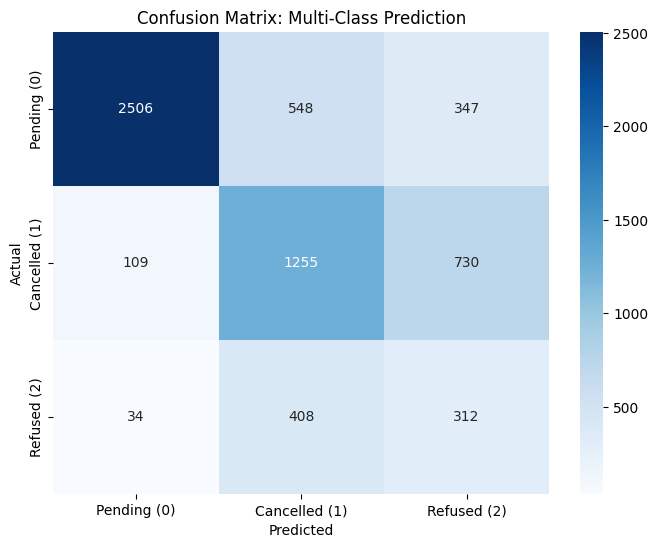

In [46]:
# --- 7. EVALUATION ---
model.eval()
with torch.no_grad():
    y_pred_logits = model(X_test_t)
    # Get the class index with the highest score
    y_pred_classes = torch.argmax(y_pred_logits, dim=1).numpy()

print("\n=== CLASSIFICATION REPORT ===")
target_names = ['Pending (0)', 'Cancelled (1)', 'Refused (2)']
print(classification_report(y_test, y_pred_classes, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Multi-Class Prediction")
plt.show()